# Functional connectomics example

## Connect to the database server

In [1]:
 # DatatJoint configuration and connection

import datajoint as dj
from getpass import getpass

dj.config['database.host'] = 'at-database.ad.bcm.edu'
dj.config['database.user'] = 'dimitri'    
dj.config['database.password'] = getpass('Password: ')
dj.config['display.limit'] = 12

Password: ········


## NDA: schema with functional data

In [2]:
%%capture
nda = dj.create_virtual_module('ta3', 'microns_nda')

## TA3: schema with structural data

In [3]:
ta3 = dj.create_virtual_module('ta3', 'microns_ta3')

## Combined structural and functional pipeline

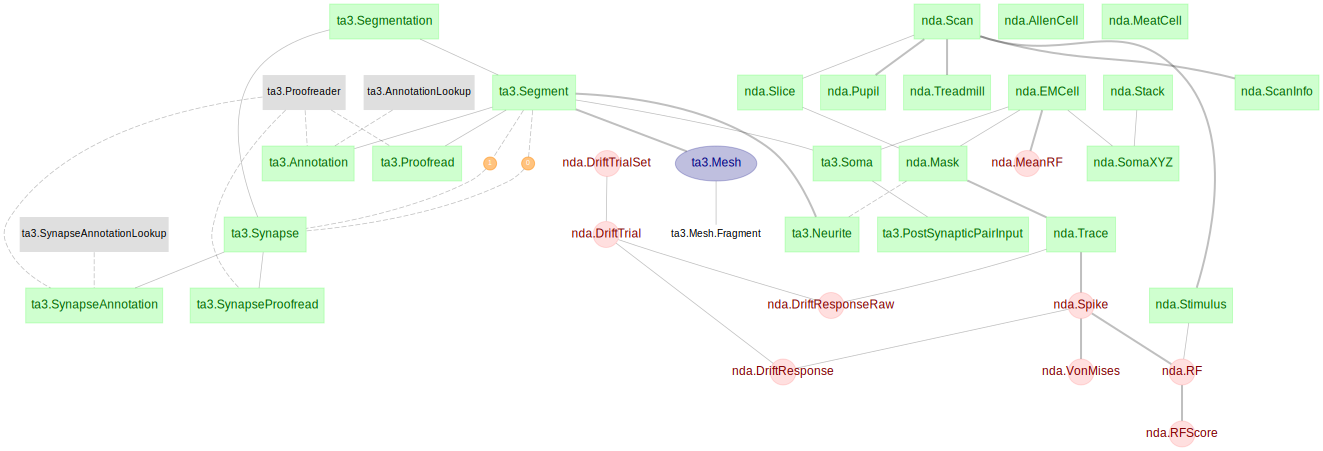

In [4]:
dj.ERD(ta3) + dj.ERD(nda)

## Functional scans

In [5]:
nda.Scan()

scan_idx scan ID,depth Scan depth from the surface (microns),laser_power Laser power (mW),wavelength Laser wavelength (nm),filename Scan base filename uploaded to S3
2,141,20,920,m8973A_00002
3,162,20,920,m8973A_00003
4,187,22,920,m8973A_00004
5,210,26,920,m8973A_00005
6,236,29,920,m8973A_00006
9,251,32,920,m8973A_00009
10,270,36,920,m8973A_00010
11,292,39,920,m8973A_00011
12,314,43,920,m8973A_00012


## Segmented cells in the EM volume

In [6]:
nda.Trace * ta3.Soma

scan_idx scan ID,slice slice number,em_id mask ID,segmentation segmentation id,segment_id segment id unique within each Segmentation,trace raw calcium trace (int16 vector)
2,1,265,1,76859794,=BLOB=
2,1,277,1,31978704,=BLOB=
2,1,281,1,101666914,=BLOB=
2,1,301,1,48618634,=BLOB=
2,1,329,1,78665518,=BLOB=
2,1,330,1,94050687,=BLOB=
2,1,331,1,90749372,=BLOB=
2,1,333,1,50725796,=BLOB=
2,1,334,1,93217930,=BLOB=
2,1,335,1,51320039,=BLOB=


## Calcium traces 

In [7]:
nda.Trace()

scan_idx scan ID,slice slice number,em_id mask ID,trace raw calcium trace (int16 vector)
2,1,11,=BLOB=
2,1,13,=BLOB=
2,1,17,=BLOB=
2,1,28,=BLOB=
2,1,38,=BLOB=
2,1,42,=BLOB=
2,1,50,=BLOB=
2,1,70,=BLOB=
2,1,100,=BLOB=
2,1,112,=BLOB=


## Calcium traces for segmented cells

In [8]:
nda.Trace & ta3.Soma

scan_idx scan ID,slice slice number,em_id mask ID,trace raw calcium trace (int16 vector)
2,1,265,=BLOB=
2,1,277,=BLOB=
2,1,281,=BLOB=
2,1,301,=BLOB=
2,1,329,=BLOB=
2,1,330,=BLOB=
2,1,331,=BLOB=
2,1,333,=BLOB=
2,1,334,=BLOB=
2,1,335,=BLOB=


## Choose an example cell and plot receptive field

In [9]:
# import matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

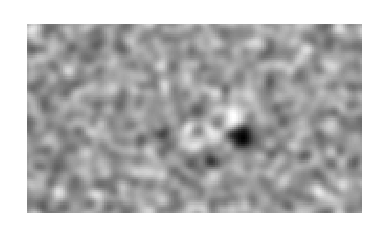

In [10]:
key = {'em_id': 396}
plt.imshow((nda.MeanRF & key).fetch1('mean_rf'), cmap='gray')
plt.axis('equal')
plt.axis('off');

## Show 3D mesh for the cell

In [11]:
# select relevant mesh fragments
fragments  = (ta3.Mesh.Fragment & (ta3.Soma & key))  

A Jupyter Widget

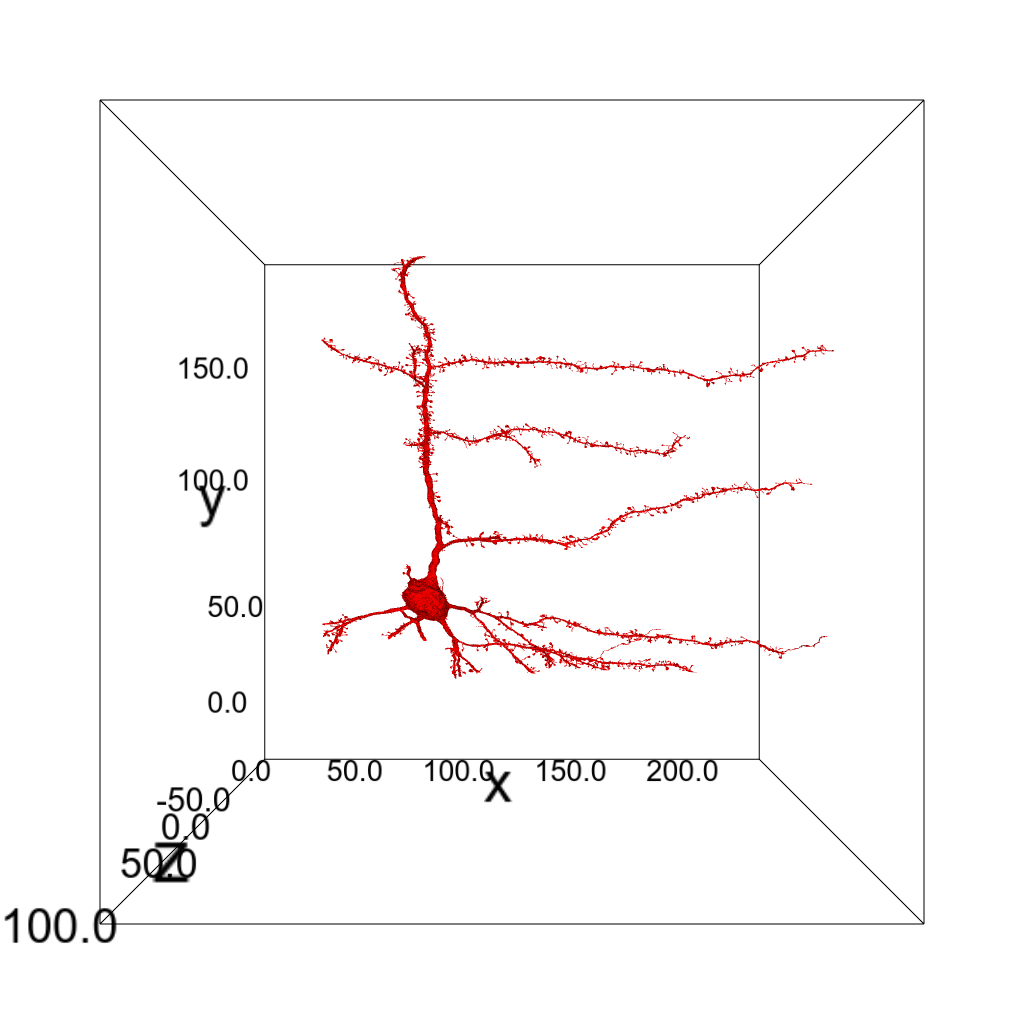

In [13]:
# interactive plot
import ipyvolume.pylab as p3   # for configuration, see https://github.com/maartenbreddels/ipyvolume
p3.figure(width=1024, height=1024)
for fragment in fragments:
    p3.plot_trisurf(*fragment['vertices'].T/1000, triangles=fragment['triangles'])
p3.squarelim()
p3.show()

In [14]:
p3.screenshot()

A Jupyter Widget

## Find cells that synapse onto the given cell

In [15]:
segments = ta3.Segment & (ta3.Soma & key)
preCells = ta3.Soma.proj(presyn='segment_id') & ta3.Synapse * segments.proj(postsyn='segment_id')

In [16]:
preCells

segmentation segmentation id,em_id mask ID,presyn segment id unique within each Segmentation
1,299,942272
1,420,50467565
1,507,48052083


## Presynaptic cells recorded in the same scan as the postsynaptic cell

In [17]:
pre_cell_mask = (nda.Mask & preCells) & (nda.Mask & key).proj(post_id='em_id')
pre_cell_mask

scan_idx scan ID,slice slice number,em_id mask ID,mask_pixels vector of pixel indices in mask
4,1,420,=BLOB=
4,1,507,=BLOB=


## Plot Ca$^{2+}$ traces for two connected cells

In [18]:
pre_trace = nda.Trace & pre_cell_mask
post_trace = nda.Trace * nda.ScanInfo & (nda.Slice & pre_cell_mask) & key

In [19]:
pre_trace

scan_idx scan ID,slice slice number,em_id mask ID,trace raw calcium trace (int16 vector)
4,1,420,=BLOB=
4,1,507,=BLOB=


In [20]:
post_trace

scan_idx scan ID,slice slice number,em_id mask ID,trace raw calcium trace (int16 vector),nframes frames recorded,px_width pixels per line,px_height lines per frame,um_width field of view width (microns),um_height field of view height (microns),bidirectional 1=bidirectional scanning,fps frames per second (Hz),zoom zoom factor (Scanimage-specific),nchannels number of recorded channels,nslices number of slices,fill_fraction raster scan fill fraction (Scanimage-specific),raster_phase shift of odd vs even raster lines
4,1,396,=BLOB=,27300,256,256,400.0,400.0,1,14.8313,2.1,2,3,0.712867,7.69014e-05


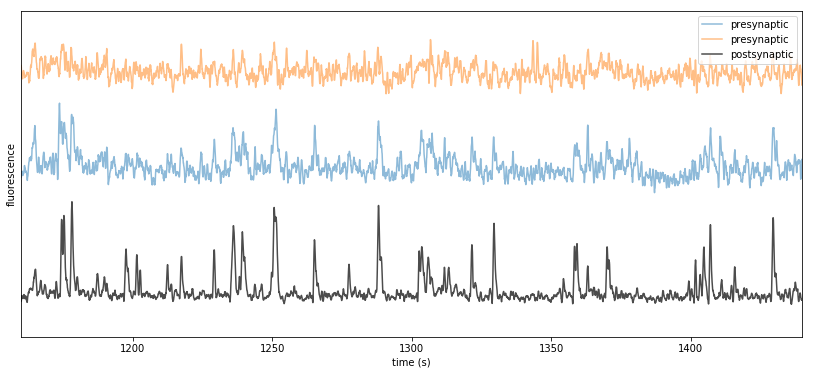

In [21]:
import numpy as np
from scipy.signal import savgol_filter
from functools import partial
rcParams['figure.figsize'] = (14, 6)
smooth = partial(savgol_filter, window_length=21, polyorder=4)
trace, fps = post_trace.fetch1('trace', 'fps', squeeze=True)
time = np.r_[:trace.size]/fps

legend = []
for pre in pre_trace:
    plt.plot(time, smooth(pre['trace'][0,:]) + len(legend)*2000, alpha=0.5)
    legend.append('presynaptic')
    
plt.plot(time, smooth(trace/4)-2000, 'k', alpha=0.7)
plt.xlim([1160, 1440])
plt.xlabel('time (s)')
plt.ylabel('fluorescence')
plt.yticks([],[])
plt.legend(legend + ['postsynaptic']);